In [1]:
# conda create --name sig_verif_1 python=3.8.19
# conda activate sig_verif_1
# conda install -c conda-forge numpy=1.24.4 pandas=1.1.4 matplotlib=3.3.3 pillow=8.1.1
# https://pytorch.org/get-started/locally/
# conda install -c conda-forge notebook
# conda install pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia

In [1]:
import notebook as x; print('Lib:', x.__version__)

# /d/Users/ali/DATA_Cheque/4_Signature_Verification/1_ICDAR_2011/Siamese-1/siamese-net
# echo $CONDA_DEFAULT_ENV

Lib: 7.2.2


In [14]:
# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import config
from utils import imshow, show_plot
from contrastive import ContrastiveLoss
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [15]:
# load the dataset
training_dir = config.training_dir
testing_dir = config.testing_dir
training_csv = config.training_csv
testing_csv = config.testing_csv

In [16]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):

        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
            # image1_path,  # Returns image1 path
            # image2_path,  # Returns image2 path
        )

    def __len__(self):
        return len(self.train_df)

In [17]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

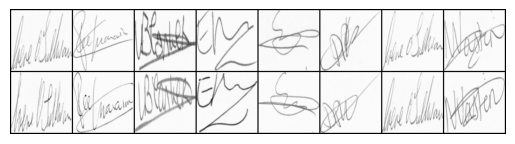

[[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [12]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
# first_column_filenames = example_batch[3]  # These are the filenames for the first image in each pair
# print("First column image filenames:")
# for filename in first_column_filenames:
#     print(filename)

In [18]:
#create a siamese network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.BatchNorm2d(96),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(p=0.3),    ####### Use nn.Dropout in newer versions not Dropout2d

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))

    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [19]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,  #.py file more workers (total=20)
                        batch_size=config.batch_size)

for i, data in enumerate(train_dataloader,0):
    print(i)
    if i> 5 : break

0
1
2
3
4
5
6


In [20]:
def calculate_bal_accuracy(output1, output2, labels, threshold=2.0):
    # Calculate the Euclidean distance between the two output embeddings
    distances = F.pairwise_distance(output1, output2)  # Euclidean distance between embeddings
    
    # Use threshold to classify genuine (0) or fraud (1)
    predicted = (distances >= threshold).float()  # 1 if dissimilar (fraud), 0 if similar (genuine)
    
    # Initialize counters for TP, TN, FP, FN
    TP = ((predicted == 1) & (labels == 1)).sum().item()  # True Positive: Predicted fraud, actually fraud
    TN = ((predicted == 0) & (labels == 0)).sum().item()  # True Negative: Predicted genuine, actually genuine
    FP = ((predicted == 1) & (labels == 0)).sum().item()  # False Positive: Predicted fraud, actually genuine
    FN = ((predicted == 0) & (labels == 1)).sum().item()  # False Negative: Predicted genuine, actually fraud
    
    # Calculate sensitivity (True Positive Rate) and specificity (True Negative Rate)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero
    
    # Calculate balanced accuracy
    bal_accuracy = (sensitivity + specificity) / 2
    
    return TP, TN, FP, FN, bal_accuracy

cuda if GPU else CPU: cuda
Epoch 1
 Avg loss 1.3906667111005337
 Lerning Rate 0.001

Epoch 2
 Avg loss 1.1707725937865654
 Lerning Rate 0.001

Epoch 3
 Avg loss 1.1634599168274358
 Lerning Rate 0.001

Epoch 4
 Avg loss 1.1663981761485749
 Lerning Rate 0.001

Epoch 5
 Avg loss 1.1626150301829514
 Lerning Rate 0.001

Epoch 6
 Avg loss 1.1620341099326603
 Lerning Rate 0.001

Epoch 7
 Avg loss 1.157456375514837
 Lerning Rate 0.001

Epoch 8
 Avg loss 1.1597902522763601
 Lerning Rate 0.001

Epoch 9
 Avg loss 1.1611601083896048
 Lerning Rate 0.001

Epoch 10
 Avg loss 1.1567036908520154
 Lerning Rate 0.001

Epoch 11
 Avg loss 1.157403242325323
 Lerning Rate 0.001

Epoch 12
 Avg loss 1.1561485930415225
 Lerning Rate 0.001

Epoch 13
 Avg loss 1.153660349691538
 Lerning Rate 0.001

Epoch 14
 Avg loss 1.1528073371113496
 Lerning Rate 0.001

Epoch 15
 Avg loss 1.1493100879441938
 Lerning Rate 0.001

Epoch 16
 Avg loss 1.1515811254006114
 Lerning Rate 0.001

Epoch 17
 Avg loss 1.1503567432076478
 Le

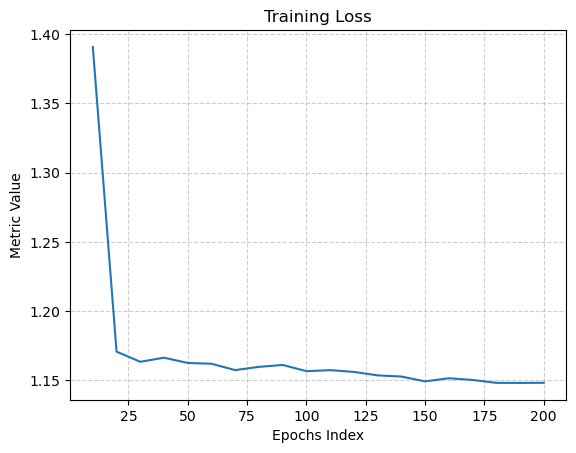

Model Saved Successfully


In [22]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
#train the model
def train():
    checkpoint_data = {
        'loss': [],
        'counter': [],
        'bal_acc': [],
        'TP': [],
        'TN': [],
        'FP': [],
        'FN': [],}
    iteration_number = 0
    L_data = len(train_dataloader)
    for epoch in range(1, 21):  #config.epochs+1 20 epochs
        loss_sum = 0
        for i, data in enumerate(train_dataloader,0):  #726 instances
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            loss_sum += loss_contrastive.item()

        iteration_number += 10
        avg_loss = loss_sum / L_data
        checkpoint_data['loss'].append(avg_loss)
        checkpoint_data['counter'].append(iteration_number)

        # Adjust learning rate
        scheduler.step(avg_loss)

        TP, TN, FP, FN, bal_acc = calculate_bal_accuracy(output1, output2, label)
        checkpoint_data['bal_acc'].append(bal_acc)
        checkpoint_data['TP'].append(TP)
        checkpoint_data['TN'].append(TN)
        checkpoint_data['FP'].append(FP)
        checkpoint_data['FN'].append(FN)
        print("Epoch {}\n Avg loss {}\n Lerning Rate {}\n".format(epoch, avg_loss, optimizer.param_groups[0]['lr']))

    # show_plot(counter, loss)
    plt.plot(checkpoint_data['counter'], checkpoint_data['loss'], label='Contrastive Loss')
    # plt.plot(checkpoint_data['counter'], checkpoint_data['bal_acc'], label='Balanced Accuracy')
    plt.title('Training Loss')  #Balanced Accuracy
    plt.xlabel('Epochs Index')
    plt.ylabel('Metric Value')
    # plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    return net, checkpoint_data  # Return all

#set the device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print(f"cuda if GPU else CPU: {device}")
model, summary = train()
# torch.save(model.state_dict(), f"content/model.pt")
print("Model Saved Successfully")

In [23]:
import json

# Assuming summary is a dictionary or serializable object
with open('model_summary.json', 'w') as f:
    json.dump(summary, f, indent=4)

In [ ]:
# # Declare Siamese Network
# net = SiameseNetwork().cuda()
# # Decalre Loss Function
# criterion = ContrastiveLoss()
# # Declare Optimizer
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)

# #train the model
# def train(train_dataloader):
#     loss=[] 
#     counter=[]
#     iteration_number = 0
#     for i, data in enumerate(train_dataloader,0):
#       img0, img1 , label = data
#       img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
#       optimizer.zero_grad()
#       output1,output2 = net(img0,img1)
#       loss_contrastive = criterion(output1,output2,label)
#       loss_contrastive.backward()
#       optimizer.step()
#       loss.append(loss_contrastive.item())
#     loss = np.array(loss)
#     return loss.mean()/len(train_dataloader)


# def eval(eval_dataloader):
#     loss=[] 
#     counter=[]
#     iteration_number = 0
#     for i, data in enumerate(eval_dataloader,0):
#       img0, img1 , label = data
#       img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
#       output1,output2 = net(img0,img1)
#       loss_contrastive = criterion(output1,output2,label)
#       loss.append(loss_contrastive.item())
#     loss = np.array(loss)
#     return loss.mean()/len(eval_dataloader)




# best_eval_loss = 9999

# for epoch in range(1, config.epochs):
#   train_loss = train(train_dataloader)
#   eval_loss = eval(eval_dataloader)

#   print(f"Training loss{train_loss}")
#   print("-"*20)
#   print(f"Eval loss{eval_loss}")

#   if eval_loss<best_eval_loss:
#     best_eval_loss = eval_loss
#     print("-"*20)
#     print(f"Best Eval loss{best_eval_loss}")
#     torch.save(net.state_dict(), "/content/model.pth")
#     print("Model Saved Successfully")

#     # 2358 min more

In [24]:
torch.save(model.state_dict(), f"content/model3.pt")
torch.save(model, f"content/full3.pt")

In [25]:
# model = torch.load("content/full2.pt")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print(f"cuda if GPU else CPU: {device}")
model.to(device)
model.eval()

# Load the test dataset
test_dataset = SiameseDataset(
    testing_csv,
    testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataloader = DataLoader(test_dataset, num_workers=0, batch_size=1, shuffle=True)  #num_workers=8

cuda if GPU else CPU: cuda


Pairs Of Signatures


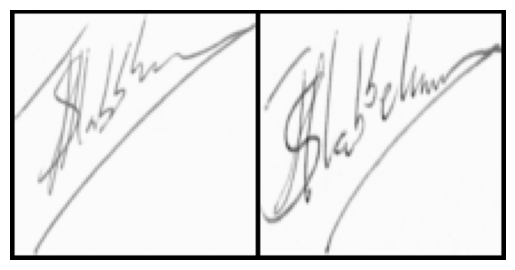

Predicted Eucledian Distance: 0.0
Contrastive Loss: 3.9999
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


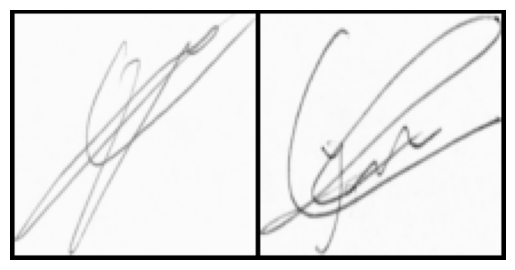

Predicted Eucledian Distance: 0.0043
Contrastive Loss: 3.9829
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


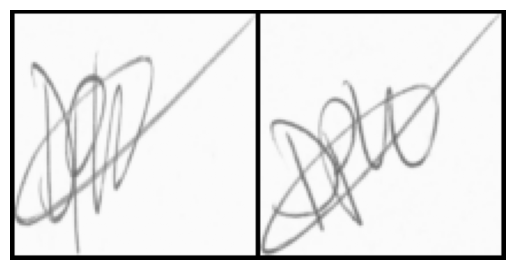

Predicted Eucledian Distance: 0.0048
Contrastive Loss: 0.0000
Actual Label: Original
Predicted: Original
-------------------------------------------------------------------


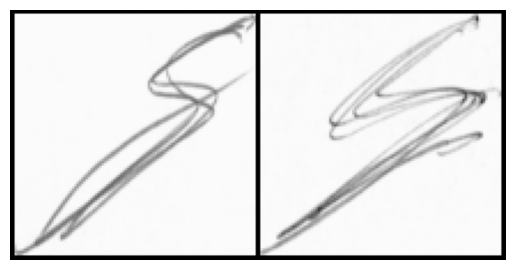

Predicted Eucledian Distance: 0.0
Contrastive Loss: 3.9999
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


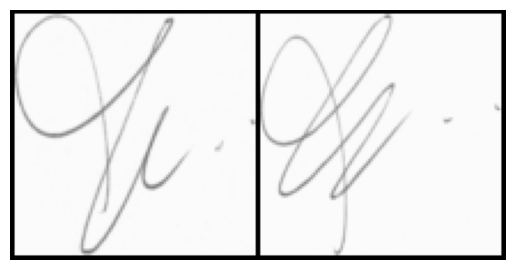

Predicted Eucledian Distance: 0.0059
Contrastive Loss: 0.0000
Actual Label: Original
Predicted: Original
-------------------------------------------------------------------


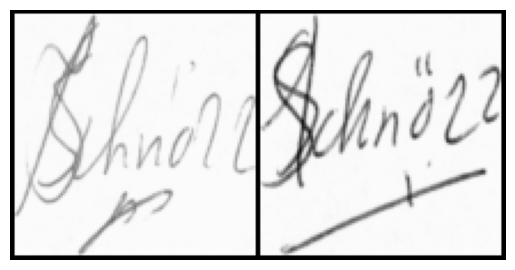

Predicted Eucledian Distance: 0.0361
Contrastive Loss: 3.8569
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


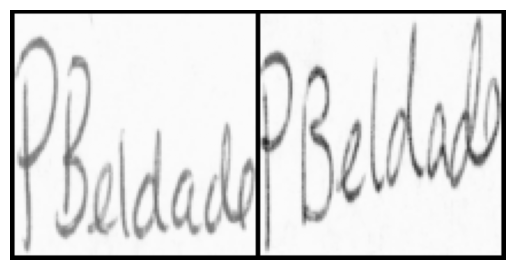

Predicted Eucledian Distance: 0.0
Contrastive Loss: 4.0000
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


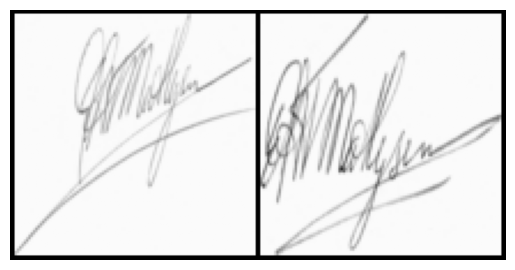

Predicted Eucledian Distance: 0.0063
Contrastive Loss: 3.9750
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


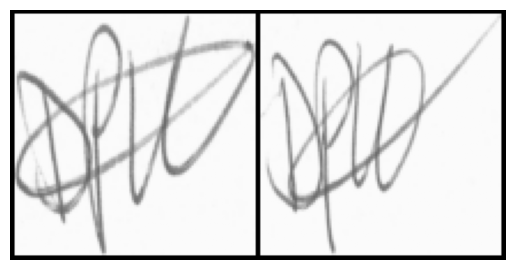

Predicted Eucledian Distance: 0.0
Contrastive Loss: 0.0000
Actual Label: Original
Predicted: Original
-------------------------------------------------------------------


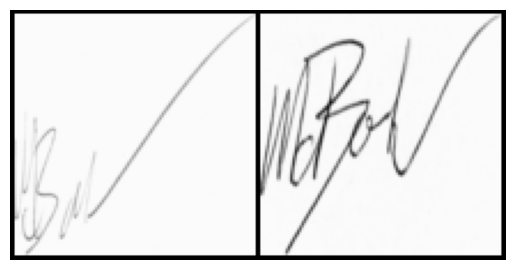

Predicted Eucledian Distance: 0.0013
Contrastive Loss: 3.9949
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


In [46]:
threshold = 2.00  # Adjust
contrastive_loss_fn = ContrastiveLoss()

print("Pairs Of Signatures")

count = 0
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1,output2 = model(x0.to(device),x1.to(device))

    eucledian_distance = F.pairwise_distance(output1, output2)

    if label.item() == 0:  #label == torch.FloatTensor([[0]]):
        label_text = "Original"
    else:
        label_text = "Forged"

    # Calculate contrastive loss for the pair
    label_tensor = label.to(device).float().view(-1)  # Ensure correct shape and type
    loss = contrastive_loss_fn(output1, output2, label_tensor)

    # Predict based on threshold
    prediction = "Forged" if loss > threshold else "Original"

    imshow(torchvision.utils.make_grid(concat))
    print("Predicted Eucledian Distance:", round(eucledian_distance.item(), 4))
    print(f"Contrastive Loss: {loss.item():.4f}")
    print("Actual Label:", label_text)
    print(f"Predicted: {prediction}")
    print("-" * 67)
    count = count + 1
    if count == 10:
        break

In [39]:
# Initialize lists to store distances and labels
distances = []
labels = []
losses = []

# Loop through the test data
count = 0
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = model(x0.to(device), x1.to(device))

    # Calculate Euclidean distance
    eucledian_distance = F.pairwise_distance(output1, output2).item()
    loss = criterion(output1, output2, label.to(device)).item()

    # Append distance and label to lists
    distances.append(eucledian_distance)
    labels.append("Genuine" if label.item() == 0 else "Forged")   #labels.append("Genuine" if label == torch.FloatTensor([[0]]) else "Forged")
    losses.append(loss)

    count += 1
#-------------------------------------------------------------------------------------
# Create a DataFrame for analysis
results_df = pd.DataFrame({
    "Distance": distances,
    "Loss": losses,
    "Label": labels
})

# Calculate statistics for genuine and forged pairs
genuine_stats = results_df[results_df["Label"] == "Genuine"][["Distance", "Loss"]].describe()
forged_stats = results_df[results_df["Label"] == "Forged"][["Distance", "Loss"]].describe()

# Print statistics
print("Genuine Pair Statistics:\n", genuine_stats)
print("\nForged Pair Statistics:\n", forged_stats)

Genuine Pair Statistics:
            Distance          Loss
count  2.772000e+03  2.772000e+03
mean   3.699766e-03  4.190183e-05
std    5.312602e-03  1.052508e-04
min    3.951179e-07  1.561181e-13
25%    3.095006e-06  9.580448e-12
50%    1.352801e-03  1.830073e-06
75%    5.616362e-03  3.154352e-05
max    2.965942e-02  8.796814e-04

Forged Pair Statistics:
           Distance         Loss
count  2975.000000  2975.000000
mean      0.008112     3.967708
std       0.009420     0.037376
min       0.000001     3.770354
25%       0.000568     3.950726
50%       0.004991     3.980059
75%       0.012357     3.997728
max       0.058260     3.999995
